# Meshing ETOPO1

In this notebook we:

1. Find the land surface in a region by filtering ETOPO1 
2. Optionally correct for the geoid (important in low-gradient / low-lying areas)
4. Create a DM object and refine a few times
5. Save the mesh to HDF5 file

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools

from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LightSource

## 1. Import coastline shapefile

This requires pyshp to be installed. We scale the points to match the dimensions of the DEM we'll use later.

In [2]:
# def remove_duplicates(a):
#     """
#     find unique rows in numpy array 
#     <http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array>
#     """
#     b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
#     dedup = np.unique(b).view(a.dtype).reshape(-1, a.shape[1])
#     return dedup

# coast_shape = shapefile.Reader("data/AustCoast/AustCoast2.shp")
# shapeRecs = coast_shape.shapeRecords()
# coords = []
# for record in shapeRecs:
#     coords.append(record.shape.points[:])
    
# coords = np.vstack(coords)

# # Remove duplicates
# points = remove_duplicates(coords)

In [17]:
## Define region of interest (here NZ)

bounds = (125.0, 30.0, 155.0, 42.0)
minX, minY, maxX, maxY = bounds

In [93]:
xres = 1000
yres = 1000

xx = np.linspace(minX, maxX, xres)
yy = np.linspace(minY, maxY, yres)
x1, y1 = np.meshgrid(xx,yy)
x1 += np.random.random(x1.shape) * 0.2 * (maxX-minX) / xres
y1 += np.random.random(y1.shape) * 0.2 * (maxY-minY) / yres

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T

In [94]:
gtiff = gdal.Open("../data/ETOPO1_Ice_c_geotiff.tif")

width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

sliceLeft   = int(180+minX) * 60
sliceRight  = int(180+maxX) * 60
sliceBottom = int(90+minY) * 60
sliceTop    = int(90+maxY) * 60

LandImg = img[ sliceLeft:sliceRight, sliceBottom:sliceTop].T
LandImg = np.flipud(LandImg)

In [95]:
# np.savez_compressed("ETOPO.npz", Description="Etopo1 Numpy Array 21600 x 10800", ETOPO1=img)



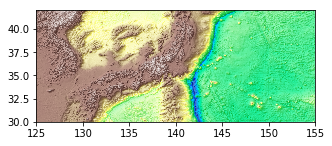

In [96]:
fig = plt.figure(1, figsize=(5,4))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
plt.show()

In [97]:
coords = np.stack((y1, x1)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [98]:
from scipy import ndimage

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest').astype(np.float)

# Fake geoid for this particular region
# meshheights -= 40.0 * (y1 - minY) / (maxY - minY)

In [99]:
## Filter out the points we don't want at all 

points = meshheights > -50 

m1s = meshheights[points]
x1s = x1[points]
y1s = y1[points]

submarine = m1s < 0.0
subaerial = m1s >= 0.0

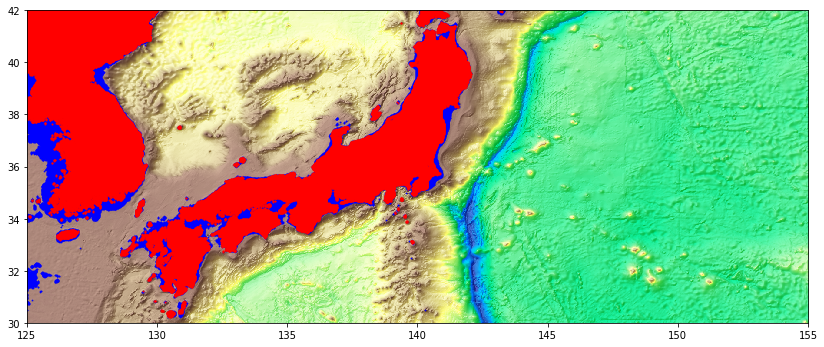

In [100]:
fig = plt.figure(1, figsize=(14,10))
ax = fig.add_subplot(111, xlim=(minX,maxX), ylim=(minY,maxY))
# ax.axis('off')

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(LandImg, cmap=cm.terrain, blend_mode='soft', vert_exag=2., dx=50, dy=50)
im1 = ax.imshow(rgb, extent=[minX, maxX, minY, maxY], cmap=cm.terrain, origin='upper')
ax.scatter(x1s[submarine], y1s[submarine], s=0.5, color="Blue")
ax.scatter(x1s[subaerial], y1s[subaerial], s=1.0, color="Red")

fig.show()

### 3. Create the DM

The points are now read into a DM and refined so that we can achieve very high resolutions. Refinement is achieved by adding midpoints along line segments connecting each point.

In [101]:
DM = meshtools.create_DMPlex_from_points(x1s, y1s, submarine, refinement_steps=1)

In [102]:
mesh = quagmire.SurfaceProcessMesh(DM, verbose=True)

0 - Delaunay triangulation 3.588368s
0 - Calculate node weights and area 0.124306s
0 - Find boundaries 0.053948s
0 - cKDTree 0.183336s
0 - Construct neighbour cloud array 4.483213s
0 - Construct rbf weights 1.023981s


In [103]:
x2r = mesh.tri.x
y2r = mesh.tri.y
simplices = mesh.tri.simplices
bmaskr = mesh.bmask

In [104]:
## Now re-do the allocation of points to the surface.
## In parallel this will be done process by process for a sub-set of points

coords = np.stack((y2r, x2r)).T

im_coords = coords.copy()
im_coords[:,0] -= minY
im_coords[:,1] -= minX

im_coords[:,0] *= LandImg.shape[0] / (maxY-minY) 
im_coords[:,1] *= LandImg.shape[1] / (maxX-minX) 
im_coords[:,0] =  LandImg.shape[0] - im_coords[:,0]

In [105]:
from scipy import ndimage

spacing = 1.0
coords = np.stack((y2r, x2r)).T / spacing

meshheights = ndimage.map_coordinates(LandImg, im_coords.T, order=3, mode='nearest')
meshheights = mesh.rbf_smoother(meshheights, iterations=2)

raw_height = meshheights.copy() * 0.001

# meshheights -= 40.0 * (y2r - minY) / (maxY - minY)

In [106]:
subaerial =  meshheights >= -0.2
submarine = ~subaerial
mesh.bmask = subaerial

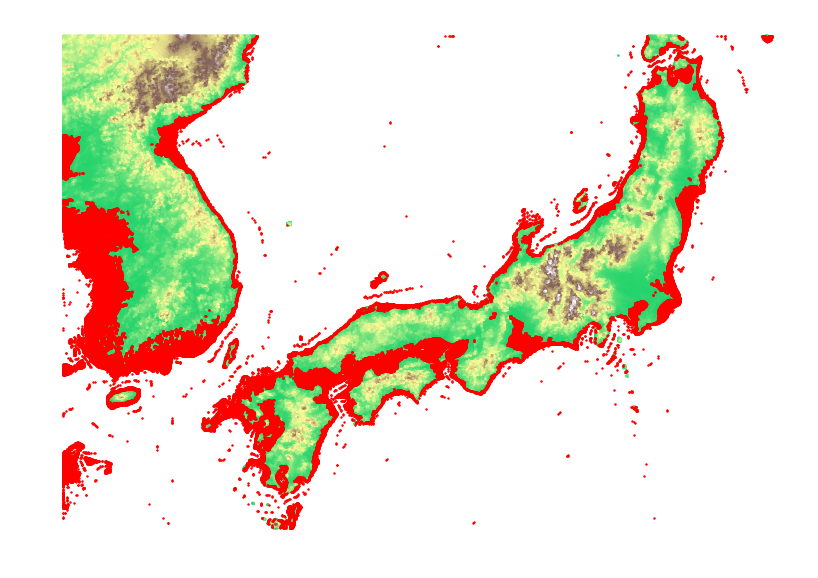

In [107]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axis('off')

sc = ax.scatter(x2r[subaerial], y2r[subaerial], s=1.0, c=meshheights[subaerial], cmap=cm.terrain, vmin=-1000.0, vmax=2500)
sc = ax.scatter(x2r[submarine], y2r[submarine], s=2.0, c="Red", alpha=1.0)
# sc = ax.scatter(x2r[hmask], y2r[hmask], s=0.5, c="Blue")


#fig.colorbar(sc, ax=ax, label='height')
fig.show()

In [108]:
# for i in range(0, 10):
#     meshheights = mesh.handle_low_points(0.0, 20)
#     mesh.update_height(meshheights)
#     low_points = mesh.identify_low_points()
#     print low_points.shape[0]
  
# m v km !

mesh.update_height(meshheights*0.001)
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour[1] == nodes)[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))  

raw_heights = mesh.height.copy()

0 - Compute slopes 4.201624s
0 - Build downhill matrices 4.58606s
mean gradient 4.57066440582
number of flat spots 13820
number of low points 3456


In [109]:
its, flowpaths1 = mesh.cumulative_flow_verbose(mesh.area, verbose=True)
flowpaths1 = mesh.rbf_smoother(flowpaths1)

0: Max Delta - 7.06987505673 
10: Max Delta - 0.00585772947123 
20: Max Delta - 0.000510128676496 
30: Max Delta - 0.000556659321212 
40: Max Delta - 0.000453140478569 
50: Max Delta - 0.000306881090242 
60: Max Delta - 0.000361676732271 
70: Max Delta - 0.000179960329335 
80: Max Delta - 0.000108687124009 
90: Max Delta - 0.000205285496096 
100: Max Delta - 0.000128783266079 
110: Max Delta - 3.44224923642e-05 
120: Max Delta - 3.55549910025e-06 
130: Max Delta - 3.29680165814e-06 
140: Max Delta - 5.67535857217e-07 


In [114]:
new_heights=mesh.low_points_local_patch_fill(its=2)
mesh._update_height_partial(new_heights)
low_points2 = mesh.identify_low_points()
print low_points2.shape

Low point local patch fill
 - Partial rebuild of downhill matrices 3.506863s
 - Partial rebuild of downhill matrices 3.43016s
Low point local patch fill  7.877405  seconds
 - Partial rebuild of downhill matrices 3.528558s
(14,)


In [111]:
new_heights = mesh.low_points_swamp_fill(ref_height=-0.01)

print new_heights.min()

107  iterations, time =  6.60503
Build low point catchments -  6.611115  seconds
0  Sort spills -  0.116761
0  Gather spill data -  0.00438300000002
0  Sort all spills -  0.00242499999996
 - Partial rebuild of downhill matrices 3.420457s
Low point swamp fill  13.043584  seconds
-0.01


In [115]:
for i in range(0,10):
    new_heights = mesh.low_points_swamp_fill(ref_height=-0.01)
    mesh._update_height_partial(new_heights)
    # mesh.update_height(new_heights)
    low_points2 = mesh.identify_low_points()
    print low_points2.shape

443  iterations, time =  27.476825
Build low point catchments -  27.483059  seconds
0  Sort spills -  0.155027
0  Gather spill data -  0.000166999999919
0  Sort all spills -  0.000106000000073
 - Partial rebuild of downhill matrices 3.491503s
Low point swamp fill  31.594474  seconds
 - Partial rebuild of downhill matrices 3.500407s
(12,)
400  iterations, time =  24.575308
Build low point catchments -  24.580272  seconds
0  Sort spills -  0.130363
0  Gather spill data -  0.000134000000003
0  Sort all spills -  9.19999999951e-05
 - Partial rebuild of downhill matrices 3.472378s
Low point swamp fill  28.629309  seconds
 - Partial rebuild of downhill matrices 3.44491s
(7,)
401  iterations, time =  24.800685
Build low point catchments -  24.806632  seconds
0  Sort spills -  0.137718
0  Gather spill data -  0.000147999999967
0  Sort all spills -  0.00010599999996
 - Partial rebuild of downhill matrices 3.462018s
Low point swamp fill  28.865165  seconds
 - Partial rebuild of downhill matrices

KeyboardInterrupt: 

In [116]:
mesh.update_height(new_heights)
lakes = mesh.height - raw_heights
# lakes[~mesh.bmask] = 0.0

print lakes.max(), mesh.height.max(), mesh.height.min()

0 - Compute slopes 4.060263s
0 - Build downhill matrices 4.004941s
4.379999999961914 3.264403971811942 -0.01


In [117]:
mesh.height.min()

-0.01

In [118]:
its, flowpaths = mesh.cumulative_flow_verbose(np.ones_like(mesh.height), verbose=True)
flowpaths2 = mesh.rbf_smoother(flowpaths, iterations=1)

0: Max Delta - 5.54923827637 
10: Max Delta - 6.87430313177 
20: Max Delta - 7.17369956149 
30: Max Delta - 6.68324307589 
40: Max Delta - 8.03821080191 
50: Max Delta - 6.74361971361 
60: Max Delta - 7.47381274111 
70: Max Delta - 8.04258418232 
80: Max Delta - 7.94261061181 
90: Max Delta - 6.68547612142 
100: Max Delta - 7.68463354068 
110: Max Delta - 7.84869559611 
120: Max Delta - 6.04218963589 
130: Max Delta - 6.15072035641 
140: Max Delta - 6.68976162565 
150: Max Delta - 7.16425483111 
160: Max Delta - 6.34003783537 
170: Max Delta - 5.66889300401 
180: Max Delta - 6.20573622887 
190: Max Delta - 6.46286379456 
200: Max Delta - 4.21655178303 
210: Max Delta - 5.92450755735 
220: Max Delta - 4.78371024292 
230: Max Delta - 4.91903114711 
240: Max Delta - 5.89836740302 
250: Max Delta - 4.28811470136 
260: Max Delta - 4.663253109 
270: Max Delta - 4.52926001147 
280: Max Delta - 4.5879992029 
290: Max Delta - 4.22632070942 
300: Max Delta - 4.06824981148 
310: Max Delta - 4.171

In [119]:
## Plane at zero height

minx = mesh.tri.x.min()
miny = mesh.tri.y.min()
maxx = mesh.tri.x.max()
maxy = mesh.tri.y.max()
refheight = -0.0005

bplanexy = np.array([ (minx, miny, refheight), 
                      (minx, maxy, refheight), 
                      (maxx, maxy, refheight), 
                      (maxx, miny, refheight)])

bplane_tri = [ (0, 1, 2), (0, 2, 3)]



In [142]:
flowpaths1a = flowpaths1.copy()
flowpaths1a[mesh.height < 0.0] = 0.00001

flowpaths2a = flowpaths2.copy()
flowpaths2a[mesh.height < 0.0] = 0.00001


In [143]:
flowpaths1a.max()

1.1619498995872748

In [146]:
manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=raw_heights*0.1, axis=1)

import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1500,1000], near=-10.0)


topo  = lv.triangles("topography",  wireframe=False)
topo.vertices(manifold)
topo.indices(mesh.tri.simplices)
topo.values(raw_heights, 'topography')
topo["zmin"] = -0.05

# topo.colourmap(["(-1.0)#FFFFFF:0.0 (-0.01)#0099FF:0.3 (0.01)#FFFF99:1.0 (0.5)#33AA11:1.0 (2.5)#886644:1.0"] , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap
topo.colourmap(["(-1.0)#FFFFFF:1.0 (-0.01)#0099FF:1.0 (0.01)#AAAAAA:1.0 (0.5)#777777:1.0 (2.5)#555555:1.0"] , logscale=False)   # Apply a built in colourmap


topo2  = lv.triangles("topography2",  wireframe=False)
topo2.vertices(manifold)
topo2.indices(mesh.tri.simplices)
topo2.values(mesh.height, 'topography')
topo2["zmin"] = -0.05

topo2.colourmap(["(-1.0)#FFFFFF:0.0 (-0.01)#0099FF:0.3 (0.01)#FFFF99:1.0 (0.5)#33AA11:1.0 (2.5)#886644:1.0"] , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap


flowpath2 = lv.triangles("flow",  wireframe=False)
flowpath2.vertices(manifold+(0.0,0.0,0.02))
flowpath2.indices(mesh.tri.simplices)
flowpath2.values(flowpaths1a, label='flow1')
flowpath2.values(flowpaths2a, label='flow2')
flowpath2["zmin"] = -0.05
flowpath2.colourmap(["#FFFFFF:0.0 #0033FF:0.3 #000033"], logscale=True)   

## LAKES / SWAMPS

lakeheight = lakes.copy()
lakeheight[lakes > 0.0]  = mesh.height[lakes > 0.0]
lakeheight[lakes <= 0.0] = 0.0 # raw_heights[lakes <= 0.0] - 0.1

manifold = np.reshape(mesh.coords, (-1,2))
manifold = np.insert(manifold, 2, values=lakeheight*0.25, axis=1)

# lakeheight[lakes <= 0.0] = 0.0

lakeview = lv.triangles("lakes",  wireframe=True, colour="#00FFEE:0.5")
lakeview.vertices(manifold+(0.0,0.0,0.02))
lakeview.indices(mesh.tri.simplices)
lakeview.values(lakeheight, 'lakes')
lakeview["zmin"] = -0.05

lakeview.colourmap(["(-1.0)#FFFFFF:0.0 (0.0)#FFFFFF:0.5 (0.05)#55FFEE:1.0 (1.0)#00FFEE:1.0"] , logscale=False, range=[0.0,1.0])   # Apply a built in colourmap

bplane = lv.triangles('bplane', wireframe=False, colour=(0.5,0.7,0.9,1.0))
bplane.vertices(bplanexy)
bplane.indices(bplane_tri)



In [147]:

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Panel()
lv.control.Checkbox(property='axis')
flowpath2.control.List(["flow1", "flow2"], property="colourby", value="flow2", command="reload")
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>


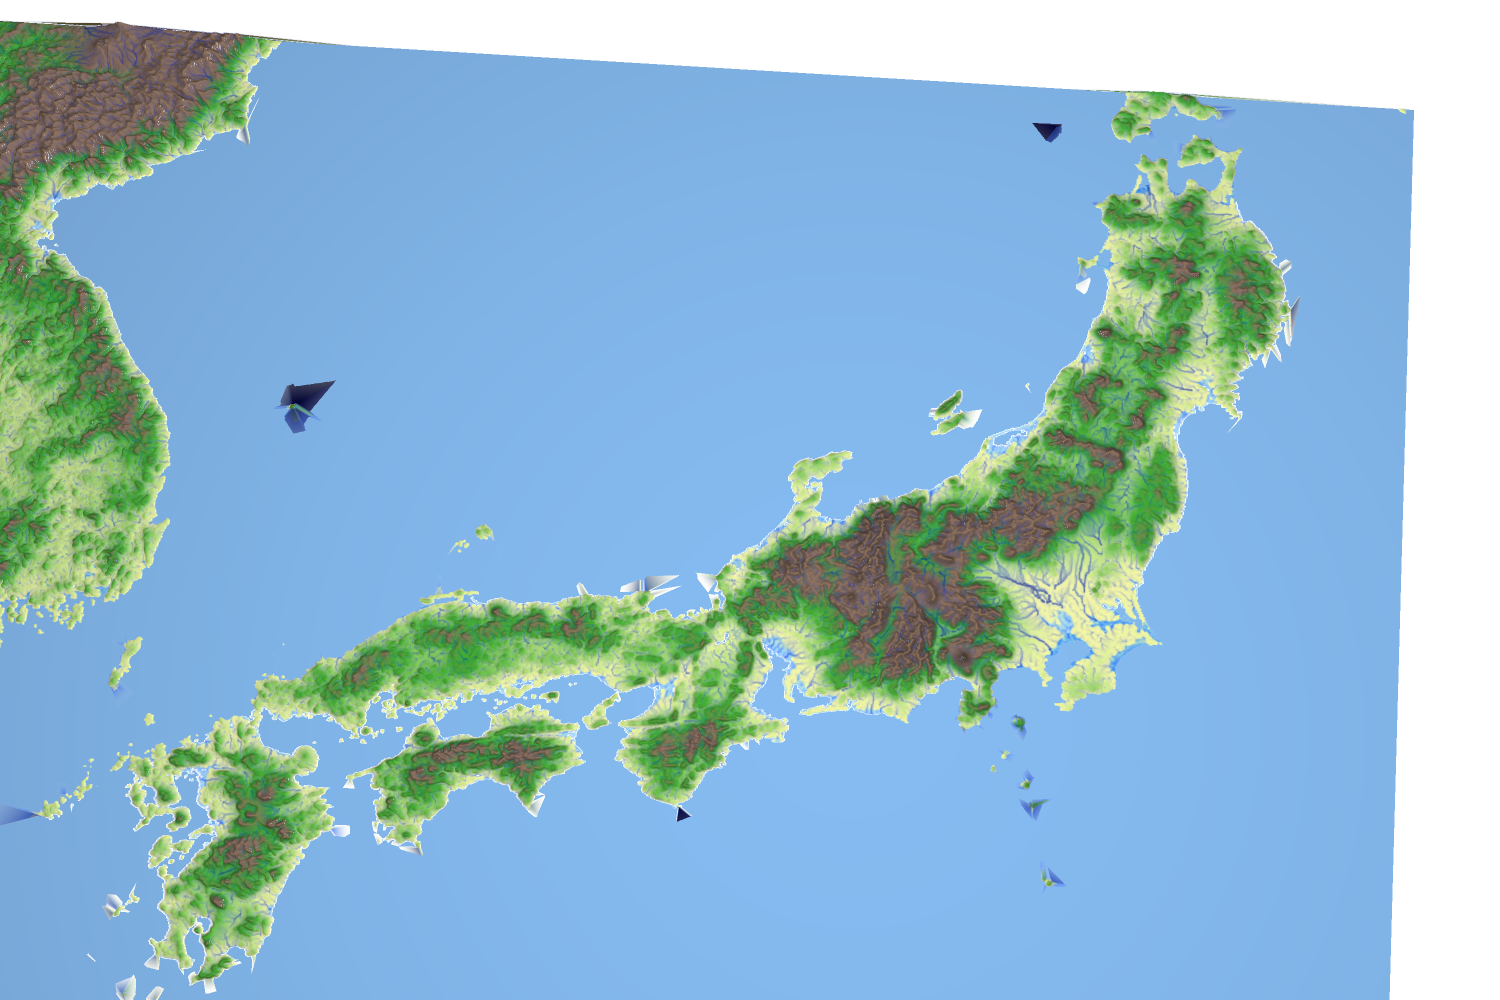

In [151]:
lv.display()

In [32]:
99 = 1

SyntaxError: can't assign to literal (<ipython-input-32-1eafd4f891c0>, line 1)

In [ ]:
manifold = np.reshape(mesh.coords[mesh.bmask], (-1,2))
manifold = np.insert(manifold, 2, values=mesh.height[mesh.bmask]*0.25, axis=1)

In [ ]:
from LavaVu import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

topo = lv.points(pointsize=2.0, pointtype=0)
topo.vertices(manifold)
topo.values(mesh.height[mesh.bmask], label='height')
# topo.values(np.sqrt(flowpaths), label='flow')

topo2 = lv.points(pointsize=2.0, pointtype=0)
topo2.vertices(manifold+(0.0,0.0,0.1))
# topo.values(mesh.height, label='height')
topo2.values(np.sqrt(flowpaths2[mesh.bmask]), label='flow')


# topo3 = lv.points(pointsize=2.0, pointtype=0)
# topo3.vertices(manifold+(0.0,0.0,0.1))
# # topo.values(mesh.height, label='height')
# topo3.values(np.sqrt(flowpathsG2[bmaskr]), label='flowG')


topo.colourmap(["#004420", "#FFFFFF", "#444444"] , logscale=False, range=[-0.2, 1.0])   # Apply a built in colourmap
# topo.colourmap(["#FFFFFF:0.0", "#0033FF:0.3", "#000033"], logscale=False)   # Apply a built in colourmap
topo2.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap

# topo3.colourmap(["#FFFFFF:0.0", "#0033FF:0.1", "#000033"], logscale=True)   # Apply a built in colourmap



In [ ]:
lv.window()

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

## 5. Save to HDF5

Save the mesh to an HDF5 file so that it can be visualised in Paraview or read into Quagmire another time. There are two ways to do this:

1. Using the `save_DM_to_hdf5` function in meshtools, or
2. Directly from trimesh interface using `save_mesh_to_hdf5` method.

Remember to execute `petsc_gen_xdmf.py austopo.h5` to create the XML file structure necessary to visualise the mesh in paraview.

In [ ]:
filename = 'NZTopo.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height=mesh.height, 
                                  height0=raw_heights,
                                  slope=mesh.slope, 
                                  flow1=np.sqrt(flowpaths1),
                                  flow2=np.sqrt(flowpaths2),
                                  lakes = lakes)

# to view in Paraview
meshtools.generate_xdmf(filename)